# Анализ сайта "СберАвтоподписка"

## Этап 1. Описательный анализ данных, портрет пользователя, посещаемость

В рамках этого этапа будет выполнено:
- Загрузка и обзор датасета
- Анализ типов данных, пропусков, базовой статистики
- Формирование портрета пользователя (устройства, города, источники трафика)
- Анализ посещаемости сайта по датам и часам


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка графиков
sns.set(style='whitegrid')

# Путь к очищенному датасету
path = '/content/drive/MyDrive/H2/data_cln.csv'

# Выбираем ключевые колонки
usecols = [
    'session_id_x', 'client_id', 'visit_date', 'visit_time', 'visit_number',
    'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
    'device_category', 'device_brand', 'device_browser',
    'geo_country', 'geo_city', 'event_action'
]

# Загружаем сэмпл (100 000 строк для EDA)
sample = pd.read_csv(path, usecols=usecols, nrows=100_000)


In [3]:
# Информация о типах данных и непустых значениях
print("Общая информация о данных:")
print(sample.info())

# Подсчёт пропусков по колонкам
print("\nКоличество пропущенных значений по колонкам:")
print(sample.isnull().sum())

# Базовая статистика по всем колонкам
print("\nБазовая статистика (включая строковые признаки):")
print(sample.describe(include='all'))

# Число уникальных значений по колонкам
print("\nУникальные значения по колонкам:")
print(sample.nunique())


Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   session_id_x     99998 non-null  object 
 1   client_id        99998 non-null  float64
 2   visit_date       99998 non-null  object 
 3   visit_time       99998 non-null  object 
 4   visit_number     99998 non-null  float64
 5   utm_source       99998 non-null  object 
 6   utm_medium       99998 non-null  object 
 7   utm_campaign     97729 non-null  object 
 8   utm_adcontent    97729 non-null  object 
 9   device_category  99998 non-null  object 
 10  device_brand     58903 non-null  object 
 11  device_browser   99998 non-null  object 
 12  geo_country      99998 non-null  object 
 13  geo_city         99998 non-null  object 
 14  event_action     99187 non-null  object 
dtypes: float64(2), object(13)
memory usage: 11.4+ MB
None

Количество пропущенны

### Вывод по описательному анализу

- В выборке 100 000 строк и 15 признаков.  
- Некоторые признаки имеют пропуски:
  - `device_brand` — наиболее проблемный (около 41% пропусков),
  - `utm_campaign`, `utm_adcontent`, `event_action` — также содержат значительные пропуски.
- Типы признаков:
  - Большинство — категориальные (`object`),
  - `client_id` и `visit_number` — числовые (`float64`).
- Число уникальных значений:
  - У `visit_time` — 24 часа,
  - `device_category` — всего 3 категории.
- Повторяемость `session_id_x`: всего 6656 уникальных значений на 100 000 строк — одна сессия включает несколько событий.
- Часто встречающиеся значения:
  - Браузер: **Chrome**,
  - Тип устройства: **mobile**,
  - Страна: **Russia**,
  - Город: **Moscow**,
  - Целевое действие: **view_card**.


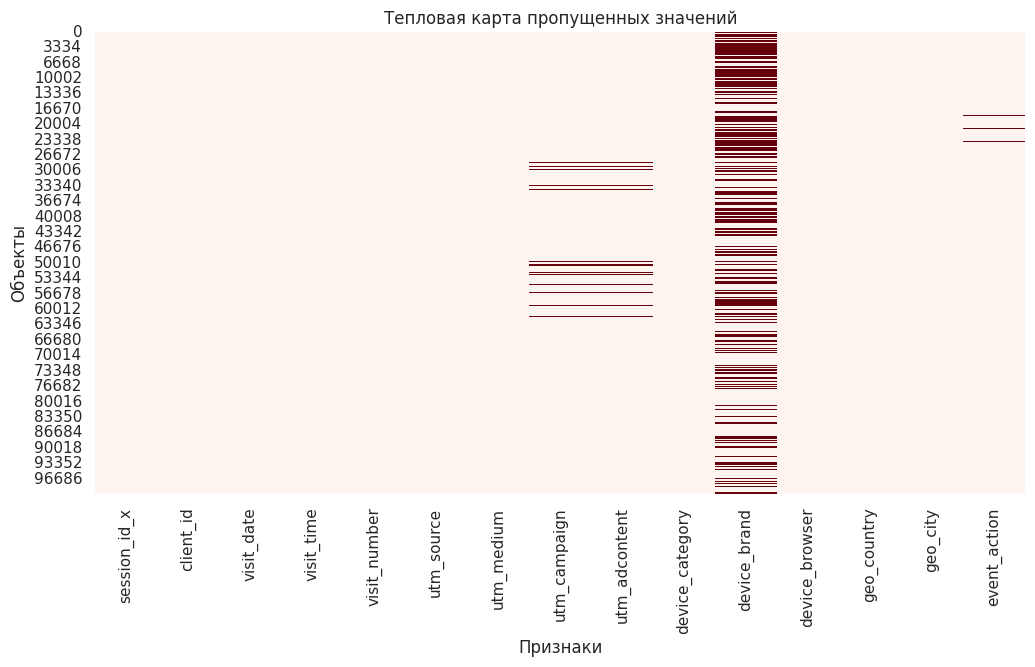

In [4]:
# визуализация пропусков

plt.figure(figsize=(12, 6))
sns.heatmap(sample.isnull(), cbar=False, cmap='Reds')
plt.title('Тепловая карта пропущенных значений')
plt.xlabel('Признаки')
plt.ylabel('Объекты')
plt.show()


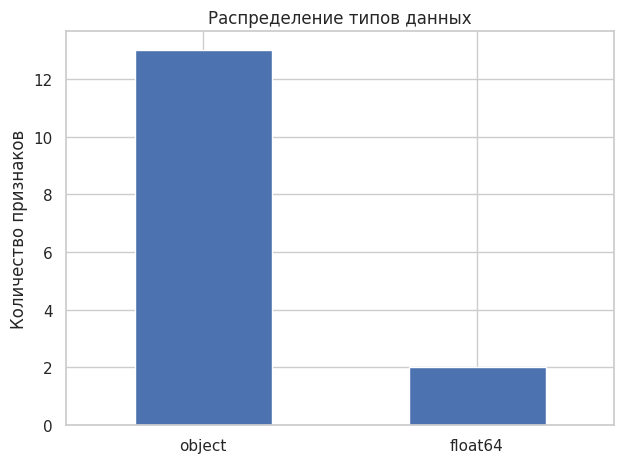

In [5]:
#распределение типов данных

sample.dtypes.value_counts().plot(kind='bar')
plt.title('Распределение типов данных')
plt.ylabel('Количество признаков')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


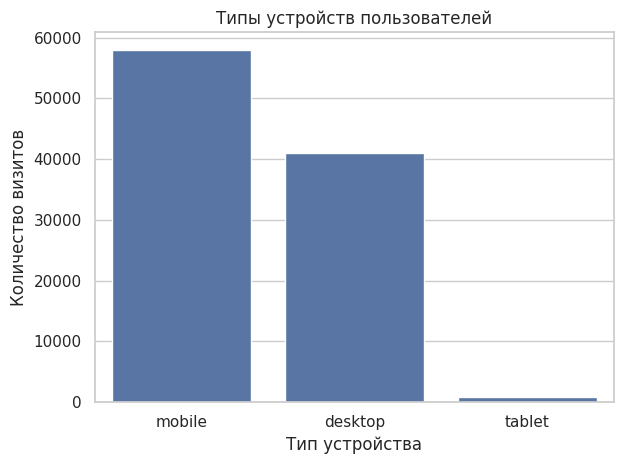

In [6]:
# Типы устройств пользователей
sns.countplot(data=sample, x='device_category', order=sample['device_category'].value_counts().index)
plt.title('Типы устройств пользователей')
plt.xlabel('Тип устройства')
plt.ylabel('Количество визитов')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


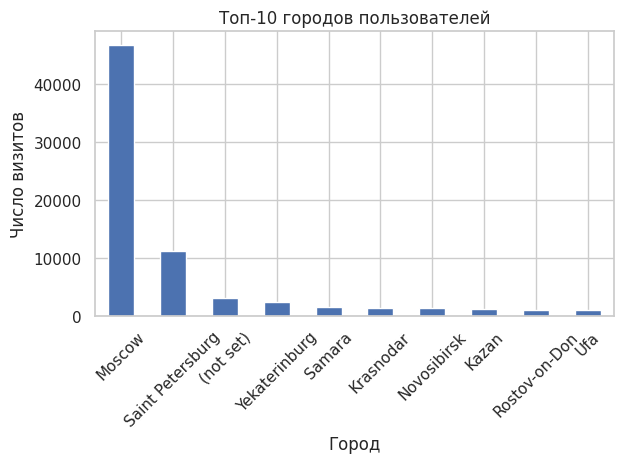

In [7]:
# Топ-10 городов пользователей
top_cities = sample['geo_city'].value_counts().head(10)
top_cities.plot(kind='bar')
plt.title('Топ-10 городов пользователей')
plt.xlabel('Город')
plt.ylabel('Число визитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


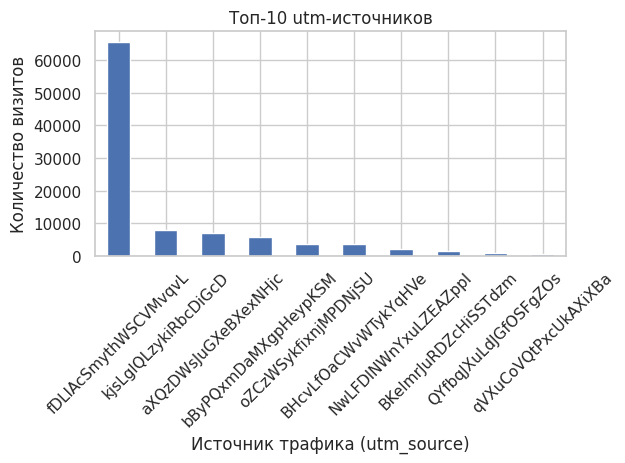

In [8]:
# Топ-10 utm-источников
top_sources = sample['utm_source'].value_counts().head(10)
top_sources.plot(kind='bar')
plt.title('Топ-10 utm-источников')
plt.xlabel('Источник трафика (utm_source)')
plt.ylabel('Количество визитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Портрет пользователя

- **Тип устройства:** Большинство пользователей заходят с мобильных устройств, затем идут десктопы, и лишь малая доля с планшетов.
- **География:** Основной трафик идёт из Москвы и Санкт-Петербурга. Также в топ входят крупные города-миллионники.
- **Источники трафика:** Один utm-источник значительно доминирует над остальными, что может указывать на основной канал привлечения аудитории.


In [9]:
# Анализ посещаемости по датам и часам

from collections import Counter
from tqdm import tqdm

# Счётчики для дат и часов визитов
visit_dates = Counter()
visit_hours = Counter()

# Чтение по частям — эффективнее для больших CSV
chunk_size = 100_000
for chunk in tqdm(pd.read_csv(path, usecols=['visit_date', 'visit_time'], chunksize=chunk_size)):
    # Учитываем даты визитов
    visit_dates.update(chunk['visit_date'].dropna())

    # Учитываем часы визитов
    hours = chunk['visit_time'].dropna().astype(str).str[:2]
    visit_hours.update(hours)


190it [01:53,  1.67it/s]


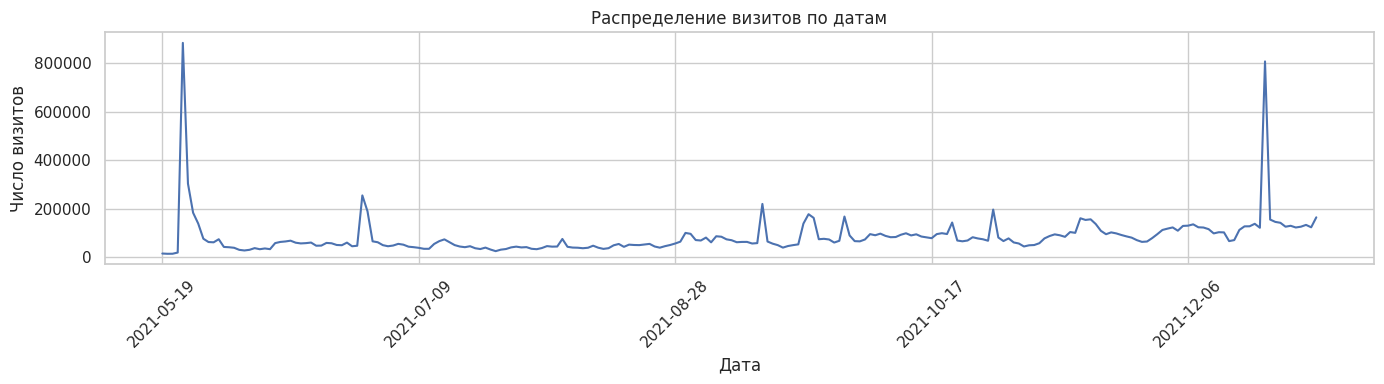

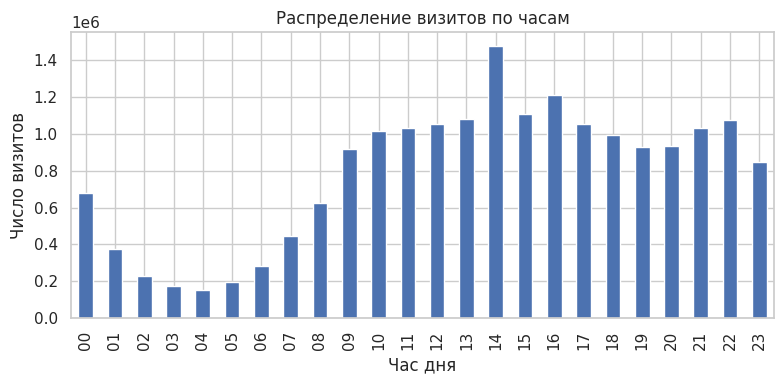

In [10]:
# График распределения визитов по датам
plt.figure(figsize=(14, 4))
pd.Series(visit_dates).sort_index().plot()
plt.title('Распределение визитов по датам')
plt.xlabel('Дата')
plt.ylabel('Число визитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График распределения визитов по часам
plt.figure(figsize=(8, 4))
pd.Series(visit_hours).sort_index().plot(kind='bar')
plt.title('Распределение визитов по часам')
plt.xlabel('Час дня')
plt.ylabel('Число визитов')
plt.tight_layout()
plt.show()


###  Посещаемость сайта

- **Пиковые часы активности** — с 10:00 до 17:00, особенно выраженный пик в 14:00–15:00. Ночью посещаемость резко снижается.
- **По датам** видно несколько сильных всплесков активности — вероятно, запуск рекламных кампаний или других маркетинговых активаций.
- В остальное время наблюдается стабильный умеренный трафик, что говорит о регулярной органической активности на сайте.

Эти наблюдения могут быть полезны при планировании рекламных акций или оценке качества привлеченного трафика.


## Общий вывод по Этапу 1

Был проведён первичный анализ данных сайта "СберАвтоподписка", в который вошли:
- **Обзор датасета:** анализ типов данных, пропусков, базовая статистика
- **Портрет пользователя:** изучены устройства, география, источники трафика
- **Посещаемость:** распределение визитов по датам и часам

Полученные инсайты могут лечь в основу гипотез для последующего анализа пользовательского поведения и построения модели.
